# CIFAR10 Image Classification using Keras

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


## Import Data

In [2]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


## Normalize

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## To Categorical

In [8]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

## Create Model # 1

- 模型采用类似于 `VGG16` 的结构：
    - 使用固定尺寸的小卷积核 (3x3)
    - 以2的幂次递增的卷积核数量 (64, 128, 256)
    - 两层卷积搭配一层池化
    - 全连接层没有采用 `VGG16` 庞大的三层结构，避免运算量过大，仅使用 128 个节点的单个FC
    - 权重初始化采用He Normal

In [51]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Flatten()(y)
y = Dense(units=128, activation='relu', kernel_initializer='he_normal')(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

# SGD (Stochastic Gradient Descent)
# lrate = 0.01
# decay = lrate / nb_epoch
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model1 = Model(inputs=x, outputs=y, name='model1')

model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 128)         0         
__________

In [52]:
nb_epoch = 100
batch_size = 256
start = time.time()
h = model1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model1.save('CIFAR10_model_no_data_augmentation.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 10s - loss: 2.0132 - acc: 0.2676 - val_loss: 1.5822 - val_acc: 0.4244
Epoch 2/100
50000/50000 [==============================] - 9s - loss: 1.5418 - acc: 0.4487 - val_loss: 1.2651 - val_acc: 0.5624
Epoch 3/100
50000/50000 [==============================] - 9s - loss: 1.2879 - acc: 0.5482 - val_loss: 1.1035 - val_acc: 0.6078
Epoch 4/100
50000/50000 [==============================] - 9s - loss: 1.0868 - acc: 0.6223 - val_loss: 1.0983 - val_acc: 0.6128
Epoch 5/100
50000/50000 [==============================] - 9s - loss: 0.9453 - acc: 0.6761 - val_loss: 0.9554 - val_acc: 0.6680
Epoch 6/100
50000/50000 [==============================] - 9s - loss: 0.8175 - acc: 0.7190 - val_loss: 0.8035 - val_acc: 0.7258
Epoch 7/100
50000/50000 [==============================] - 9s - loss: 0.7194 - acc: 0.7525 - val_loss: 0.9550 - val_acc: 0.6772
Epoch 8/100
50000/50000 [============================

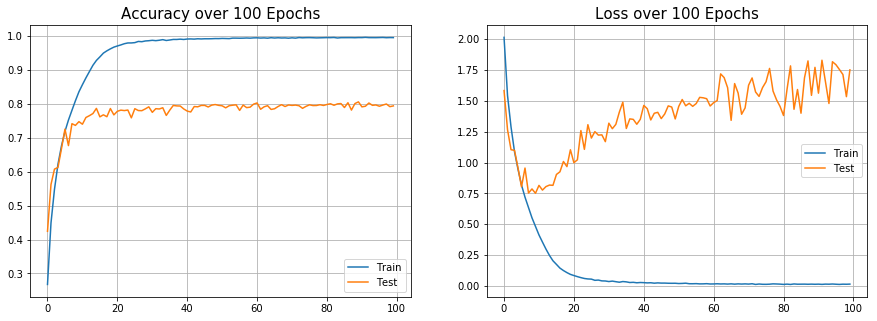

In [53]:
def plot_acc_loss(h, nb_epoch):
    acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(nb_epoch), acc, label='Train')
    plt.plot(range(nb_epoch), val_acc, label='Test')
    plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(nb_epoch), loss, label='Train')
    plt.plot(range(nb_epoch), val_loss, label='Test')
    plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(h, nb_epoch)

### 可以看到，采用类VGG结构的网络可以在100代训练中收敛至准确率80%。

In [54]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 99.92 %     loss = 0.003018
Testing Accuracy = 79.43 %    loss = 1.750089


## Further Training with Data Augmentation

In [55]:
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)
h = model1.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))
model1.save('CIFAR10_model_with_data_augmentation.h5')

Epoch 1/100
195/195 [==============================] - 10s - loss: 0.7602 - acc: 0.7791 - val_loss: 0.6648 - val_acc: 0.8054
Epoch 2/100
195/195 [==============================] - 10s - loss: 0.5934 - acc: 0.8189 - val_loss: 0.5908 - val_acc: 0.8158
Epoch 3/100
195/195 [==============================] - 10s - loss: 0.5416 - acc: 0.8287 - val_loss: 0.5641 - val_acc: 0.8196
Epoch 4/100
195/195 [==============================] - 10s - loss: 0.4983 - acc: 0.8403 - val_loss: 0.5972 - val_acc: 0.8296
Epoch 5/100
195/195 [==============================] - 10s - loss: 0.4797 - acc: 0.8455 - val_loss: 0.5521 - val_acc: 0.8338
Epoch 6/100
195/195 [==============================] - 10s - loss: 0.4494 - acc: 0.8555 - val_loss: 0.5502 - val_acc: 0.8295
Epoch 7/100
195/195 [==============================] - 10s - loss: 0.4265 - acc: 0.8629 - val_loss: 0.5424 - val_acc: 0.8370
Epoch 8/100
195/195 [==============================] - 10s - loss: 0.4064 - acc: 0.8670 - val_loss: 0.5062 - val_acc: 0.8352


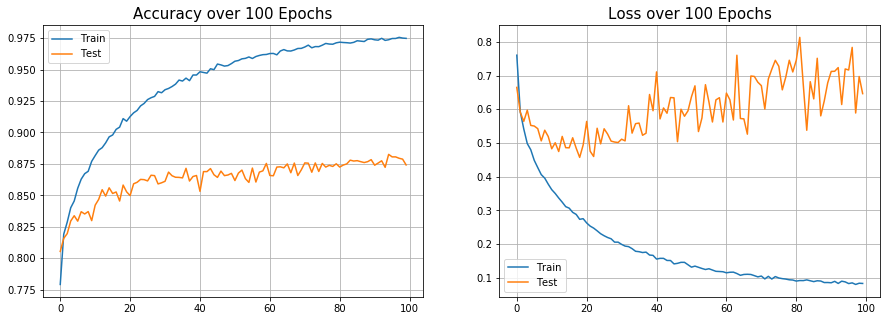

In [56]:
plot_acc_loss(h, nb_epoch)

### 可以看到，使用数据增强后继续训练模型，可以将准确率从80%提升至87%。

In [57]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 99.41 %     loss = 0.022593
Testing Accuracy = 87.42 %    loss = 0.646288


In [33]:
model1.save('CIFAR10_model_with_data_augmentation_0.88.h5')

In [38]:
model1 = load_model('CIFAR10_model_with_data_augmentation_0.88.h5')

## Create Model 2 - Batch Norm

In [58]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Flatten()(y)
y = Dense(units=128, activation='relu', kernel_initializer='he_normal')(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

# SGD (Stochastic Gradient Descent)
# lrate = 0.01
# decay = lrate / nb_epoch
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model2 = Model(inputs=x, outputs=y, name='model2')

model2.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
__________

In [59]:
nb_epoch = 100
batch_size = 256
start = time.time()
h = model2.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))
model2.save('CIFAR10_model_no_data_augmentation_BN.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 18s - loss: 1.7242 - acc: 0.3890 - val_loss: 2.0180 - val_acc: 0.2580
Epoch 2/100
50000/50000 [==============================] - 16s - loss: 1.3377 - acc: 0.5282 - val_loss: 1.2614 - val_acc: 0.5571
Epoch 3/100
50000/50000 [==============================] - 16s - loss: 1.1178 - acc: 0.6119 - val_loss: 1.0913 - val_acc: 0.6062
Epoch 4/100
50000/50000 [==============================] - 16s - loss: 0.9606 - acc: 0.6681 - val_loss: 1.0528 - val_acc: 0.6515
Epoch 5/100
50000/50000 [==============================] - 16s - loss: 0.8429 - acc: 0.7119 - val_loss: 1.1813 - val_acc: 0.5988
Epoch 6/100
50000/50000 [==============================] - 16s - loss: 0.7450 - acc: 0.7428 - val_loss: 1.0895 - val_acc: 0.6511
Epoch 7/100
50000/50000 [==============================] - 16s - loss: 0.6699 - acc: 0.7699 - val_loss: 0.9586 - val_acc: 0.6894
Epoch 8/100
50000/50000 [======================

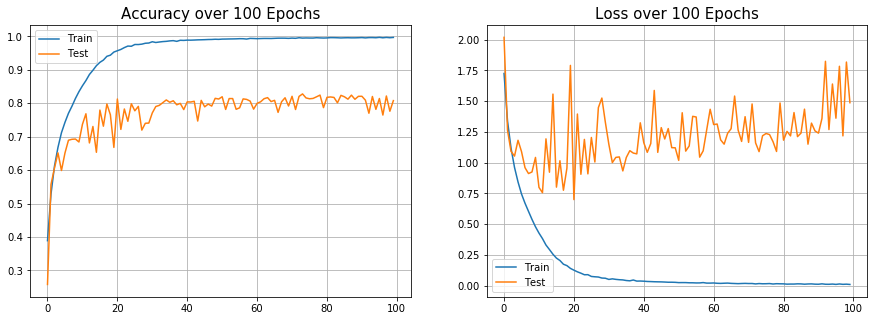

In [60]:
plot_acc_loss(h, nb_epoch)

### 加入BN应该能够使网络的收敛速度有所提高。

In [62]:
loss, accuracy = model2.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 98.75 %     loss = 0.070851
Testing Accuracy = 80.79 %    loss = 1.486847


## Create Model #3 - Dual GPU Training

In [72]:
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda
from keras.models import Model
import tensorflow as tf

def make_parallel(model, gpu_count):

    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([shape[:1] // parts, shape[1:]], axis=0)
        stride = tf.concat([shape[:1] // parts, shape[1:] * 0], axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    # Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                # Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx': i, 'parts': gpu_count})(x)
                    inputs.append(slice_n)

                outputs = model(inputs)

                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    # 也可以设为GPU，如果CPU负载已经很大的话
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(Concatenate(axis=0)(outputs))
        return Model(model.inputs, merged)


In [75]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Flatten()(y)
y = Dense(units=128, activation='relu', kernel_initializer='he_normal')(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

# SGD (Stochastic Gradient Descent)
# lrate = 0.01
# decay = lrate / nb_epoch
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model3 = Model(inputs=x, outputs=y, name='model1')

model3 = make_parallel(model3, 2)

model3.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 32, 32, 3)     0           input_17[0][0]                   
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 32, 32, 3)     0           input_17[0][0]                   
____________________________________________________________________________________________________
model1 (Model)                   (None, 10)            1671114     lambda_3[0][0]                   
                                                                   lambda_4[0][0]          

In [76]:
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)
h = model3.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))
model3.save('CIFAR10_model_with_data_augmentation_dual_GPU.h5')

Epoch 1/100
195/195 [==============================] - 13s - loss: 2.0169 - acc: 0.2599 - val_loss: 1.6660 - val_acc: 0.4055
Epoch 2/100
195/195 [==============================] - 11s - loss: 1.6283 - acc: 0.4108 - val_loss: 1.3916 - val_acc: 0.4973
Epoch 3/100
195/195 [==============================] - 11s - loss: 1.4173 - acc: 0.4938 - val_loss: 1.1105 - val_acc: 0.6125
Epoch 4/100
195/195 [==============================] - 10s - loss: 1.2385 - acc: 0.5653 - val_loss: 1.0590 - val_acc: 0.6269
Epoch 5/100
195/195 [==============================] - 11s - loss: 1.0924 - acc: 0.6214 - val_loss: 0.9224 - val_acc: 0.6753
Epoch 6/100
195/195 [==============================] - 10s - loss: 0.9861 - acc: 0.6623 - val_loss: 0.7903 - val_acc: 0.7265
Epoch 7/100
195/195 [==============================] - 10s - loss: 0.8996 - acc: 0.6911 - val_loss: 0.7734 - val_acc: 0.7313
Epoch 8/100
195/195 [==============================] - 10s - loss: 0.8280 - acc: 0.7152 - val_loss: 0.6874 - val_acc: 0.7618


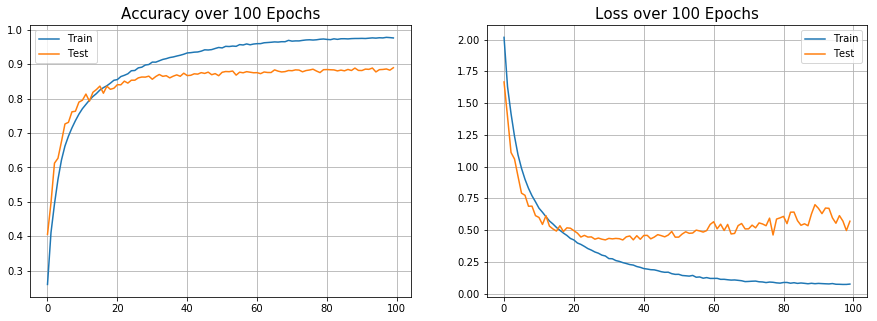

In [77]:
plot_acc_loss(h, nb_epoch)

### 可以看到，使用双卡可以在100代内将未训练的模型准确率直接提升至89%。

In [79]:
loss, accuracy = model3.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 99.45 %     loss = 0.018501
Testing Accuracy = 89.00 %    loss = 0.569403


## Continue Training for another 100 Epochs

In [80]:
h = model3.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))
model3.save('CIFAR10_model_with_data_augmentation_dual_GPU.h5')

Epoch 1/100
195/195 [==============================] - 11s - loss: 0.0706 - acc: 0.9783 - val_loss: 0.6915 - val_acc: 0.8870
Epoch 2/100
195/195 [==============================] - 10s - loss: 0.0685 - acc: 0.9778 - val_loss: 0.6965 - val_acc: 0.8823
Epoch 3/100
195/195 [==============================] - 10s - loss: 0.0736 - acc: 0.9774 - val_loss: 0.6382 - val_acc: 0.8901
Epoch 4/100
195/195 [==============================] - 10s - loss: 0.0725 - acc: 0.9778 - val_loss: 0.5873 - val_acc: 0.8870
Epoch 5/100
195/195 [==============================] - 10s - loss: 0.0715 - acc: 0.9777 - val_loss: 0.5816 - val_acc: 0.8905
Epoch 6/100
195/195 [==============================] - 10s - loss: 0.0682 - acc: 0.9794 - val_loss: 0.6123 - val_acc: 0.8860
Epoch 7/100
195/195 [==============================] - 10s - loss: 0.0722 - acc: 0.9776 - val_loss: 0.6525 - val_acc: 0.8808
Epoch 8/100
195/195 [==============================] - 10s - loss: 0.0688 - acc: 0.9784 - val_loss: 0.6851 - val_acc: 0.8850


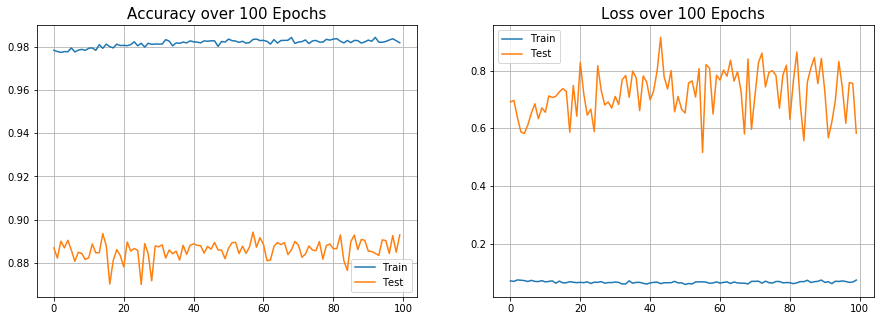

In [81]:
plot_acc_loss(h, nb_epoch)

### 可以看到，第二个100代训练的提升几乎是微乎其微的。模型基本已经收敛。

In [82]:
loss, accuracy = model3.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 99.44 %     loss = 0.028977
Testing Accuracy = 89.30 %    loss = 0.583130


## Summary


Model | Data Augmentation | Accuracy (Train) | Accracy (Test) | Epochs |
----  | ----              | ----             | ----           | ----
Conv (64, 64, 128, 128, 256, 256), FC(128) | No | 99% | 80% | 100
Conv (64, 64, 128, 128, 256, 256), FC(128) | Yes | 99% | 87% | 100
Conv (64, 64, 128, 128, 256, 256), FC(128), Dual GPU Training | Yes | 99% | 89% | 100
Conv (64, 64, 128, 128, 256, 256), FC(128), BN after each CONV | No | 98% | 80% | 100